In [2]:
import numpy as np
import pandas as pd
import os
import imageio.v2 as imageio
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:

df = pd.read_csv('old_faithful.csv')

print(df.head())

   eruptions  waiting
0      3.600       79
1      1.800       54
2      3.333       74
3      2.283       62
4      4.533       85


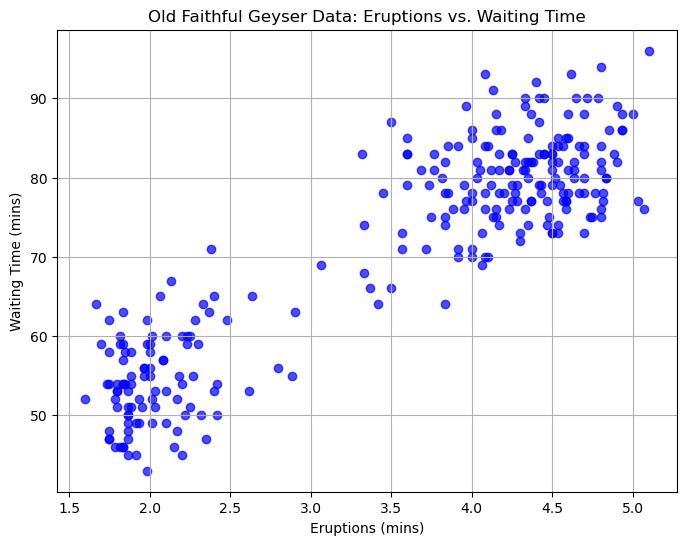

In [4]:
# Part A
plt.figure(figsize=(8,6))

plt.scatter(df['eruptions'], df['waiting'], color='blue', alpha=0.7)

plt.title('Old Faithful Geyser Data: Eruptions vs. Waiting Time')
plt.xlabel('Eruptions (mins)')
plt.ylabel('Waiting Time (mins)')

plt.grid(True)
plt.show()

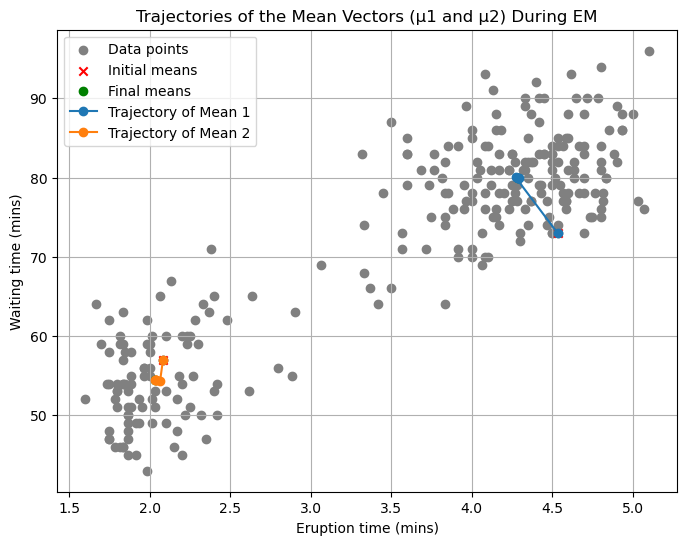

In [7]:
# Part D
X = df[['eruptions', 'waiting']].values

def multivariate_gaussian(x, mean, cov):
    d = len(mean)
    exp_term = np.exp(-0.5 * np.dot(np.dot((x - mean).T, np.linalg.inv(cov)), (x - mean)))
    return exp_term / (np.sqrt((2 * np.pi) ** d * np.linalg.det(cov)))


def initialize_parameters(X, k):
    n, d = X.shape
    means = X[np.random.choice(n, k, False), :]
    covariances = [np.eye(d) for _ in range(k)]
    mixing_coeffs = np.ones(k) / k
    return means, covariances, mixing_coeffs

# E Step Alogorithm 
def e_step(X, means, covariances, mixing_coeffs, k):
    n = X.shape[0]
    responsibilities = np.zeros((n, k))
    for i in range(n):
        for j in range(k):
            responsibilities[i, j] = mixing_coeffs[j] * multivariate_gaussian(X[i], means[j], covariances[j])
        responsibilities[i, :] /= np.sum(responsibilities[i, :])
    return responsibilities

# M-Step (ii) 
def m_step(X, responsibilities, k):
    n, d = X.shape
    N_k = np.sum(responsibilities, axis=0)  # Total responsibility for each cluster
    means = np.dot(responsibilities.T, X) / N_k[:, None]  # Update means
    covariances = []
    for j in range(k):
        diff = X - means[j]
        covariances.append(np.dot(responsibilities[:, j] * diff.T, diff) / N_k[j])
    mixing_coeffs = N_k / n  # Update mixing coefficients
    return means, covariances, mixing_coeffs

def compute_log_likelihood(X, means, covariances, mixing_coeffs, k):
    n = X.shape[0]
    log_likelihood = 0
    for i in range(n):
        p_x = 0
        for j in range(k):
            p_x += mixing_coeffs[j] * multivariate_gaussian(X[i], means[j], covariances[j])
        log_likelihood += np.log(p_x)
    return log_likelihood

# EM algorithm (i)
def em_algorithm(X, k, tol=1e-4, max_iter=100):
    means, covariances, mixing_coeffs = initialize_parameters(X, k)
    log_likelihoods = []
    means_trajectory = [means.copy()]  # Store trajectory of means for plotting

    for iteration in range(max_iter):
        # E-step
        responsibilities = e_step(X, means, covariances, mixing_coeffs, k)
        
        # M-step
        means, covariances, mixing_coeffs = m_step(X, responsibilities, k)
        means_trajectory.append(means.copy())

        log_likelihood = compute_log_likelihood(X, means, covariances, mixing_coeffs, k)
        log_likelihoods.append(log_likelihood)

        # Check for convergence (termination criterion)
        if iteration > 0 and np.abs(log_likelihood - log_likelihoods[-2]) < tol:
            break

    return means, covariances, mixing_coeffs, log_likelihoods, means_trajectory

k = 2  
means, covariances, mixing_coeffs, log_likelihoods, means_trajectory = em_algorithm(X, k)

# Plot trajectories of the mean vectors (µ1 and µ2) in 2D (iii) 
means_trajectory = np.array(means_trajectory)

plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], c='gray', marker='o', label='Data points')

plt.scatter(means_trajectory[0, :, 0], means_trajectory[0, :, 1], c='red', label='Initial means', marker='x')
plt.scatter(means_trajectory[-1, :, 0], means_trajectory[-1, :, 1], c='green', label='Final means', marker='o')

for j in range(k):
    plt.plot(means_trajectory[:, j, 0], means_trajectory[:, j, 1], marker='o', label=f'Trajectory of Mean {j+1}')

plt.title('Trajectories of the Mean Vectors (µ1 and µ2) During EM')
plt.xlabel('Eruption time (mins)')
plt.ylabel('Waiting time (mins)')
plt.legend()
plt.grid(True)
plt.show()


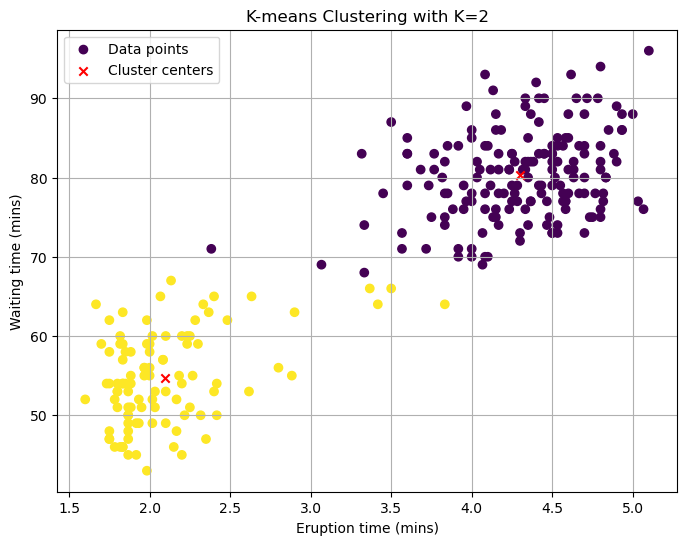

In [6]:
# Part E 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

kmeans_centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', marker='o', label='Data points')

plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', marker='x', label='Cluster centers')

plt.title('K-means Clustering with K=2')
plt.xlabel('Eruption time (mins)')
plt.ylabel('Waiting time (mins)')
plt.legend()
plt.grid(True)
plt.show()
